# Import Packages:

In [1]:
import os
import numpy as np
from typing import List, Callable, Tuple
from matplotlib import pyplot as plt
from pyimzml.ImzMLParser import (ImzMLParser, _bisect_spectrum)
from skimage import (filters, io, transform, color)
from pystackreg import StackReg

# Hellper functions:

In [2]:
def get_ion_image(p: ImzMLParser,
                  mz_values: List[float],
                  tol: float = 0.1,
                  z: int = 1,
                  reduce_func: Callable = sum) -> np.ndarray:
    """
    Get an image representation of the intensity distribution
    of the ion with specified m/z values.

    By default, the intensity values within the tolerance region are summed.

    Args:
        p (ImzMLParser): the ImzMLParser (or anything else with similar
        attributes) for the desired dataset.
        mz_values (List[float]): m/z values for which the ion image
        shall be returned
        tol (float, optional): Absolute tolerance for the m/z value,
        such that all ions with values mz_value-|tol| <= x <= mz_value+|tol|
        are included. Defaults to 0.1
        z (int, optional): z Value if spectrogram is 3-dimensional.
        Defaults to 1.
        reduce_func (Callable, optional): the bahaviour for reducing the
        intensities between mz_value-|tol| and mz_value+|tol| to a single
        value. Must be a function that takes a sequence as input and outputs
        a number. By default, the values are summed. Defaults to sum.

    Returns:
        [np.ndarray]: numpy matrix with each element representing the
        ion intensity in this pixel. Can be easily plotted with matplotlib

    """
    tol = abs(tol)
    max_y = p.imzmldict["max count of pixels y"]
    max_x = p.imzmldict["max count of pixels x"]
    ims = [np.zeros((max_y, max_x)) for _ in range(0, len(mz_values))]
    for i, (x, y, z_) in enumerate(p.coordinates):
      if z_ == 0:
        UserWarning(("z coordinate = 0 present, if you're getting blank "
                     "images set getionimage(.., .., z=0)"))
      if z_ == z:
        mzs, ints = map(np.asarray, p.getspectrum(i))
        for j, mz_value in enumerate(mz_values):
          im = ims[j]
          min_i, max_i = _bisect_spectrum(mzs, mz_value, tol)
          im[y - 1, x - 1] = reduce_func(ints[min_i:max_i + 1])
    return ims

# Global Variables:

In [3]:
# set path containing the MSI dataset
msi_data_p = "/sise/assafzar-group/assafzar/Leor/DHG/Cropped/TIC-normalized/"

# set path containing the DHG H&E images
he_data_p = "/sise/assafzar-group/assafzar/Leor/DHG/H&E/"

# define the m/z values we wish to visualize
plot_mz = [749.5, 834.5, 888.6]
# define the tolerance for retrieving an m/z value
plot_tol = 0.025
# define plot full brithness percenbtage treshould
plot_tresh = 75

# MSI and H&E Registration:

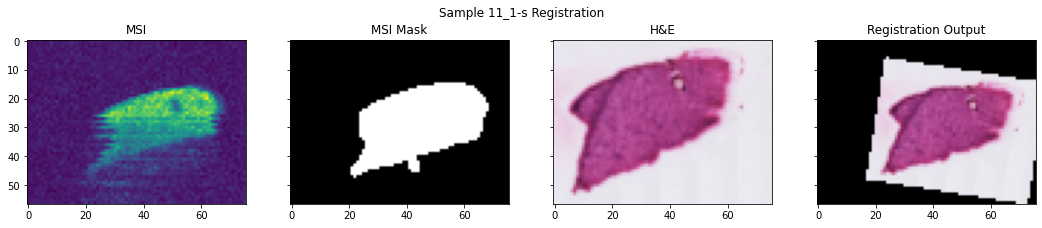

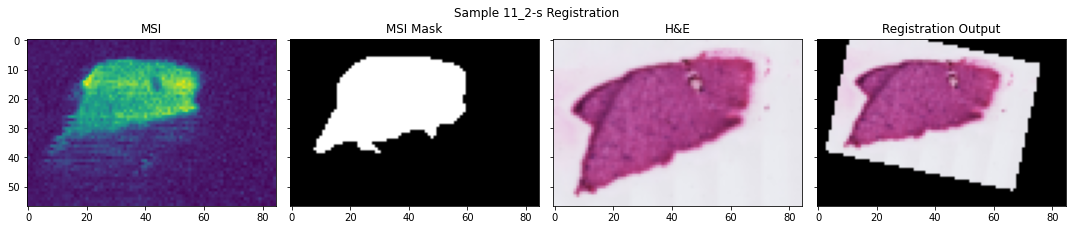

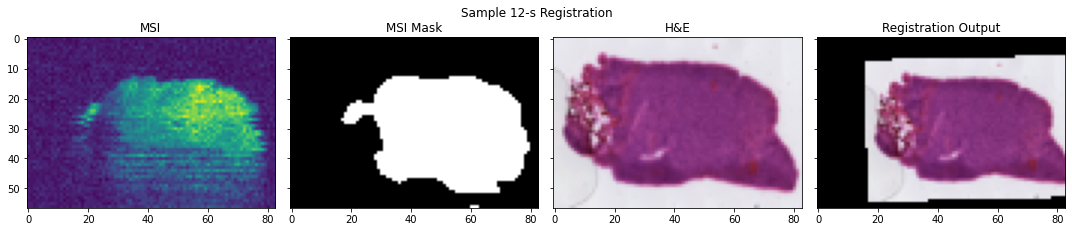

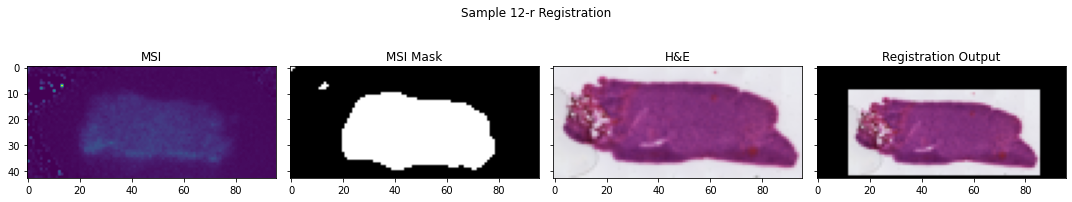

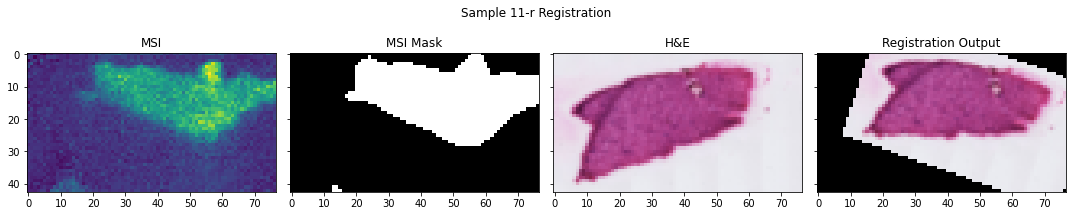

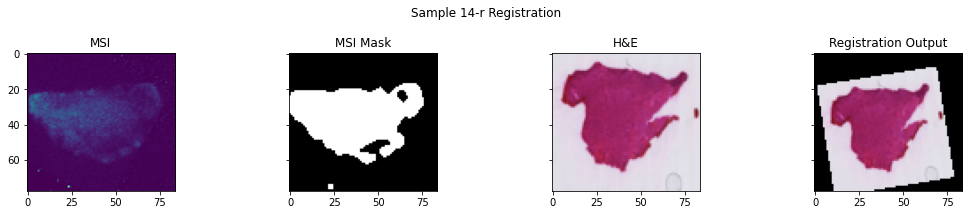

13-r


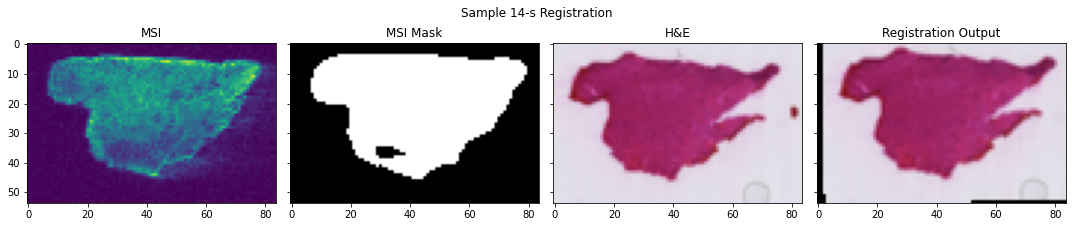

13-s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


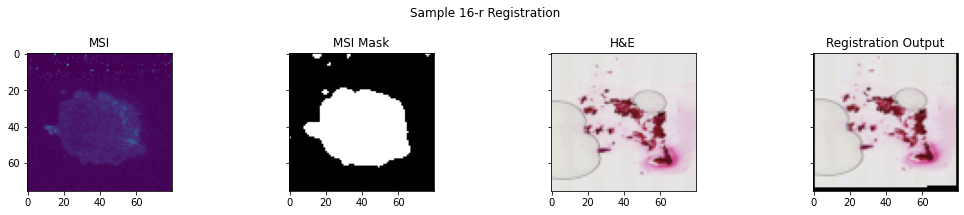

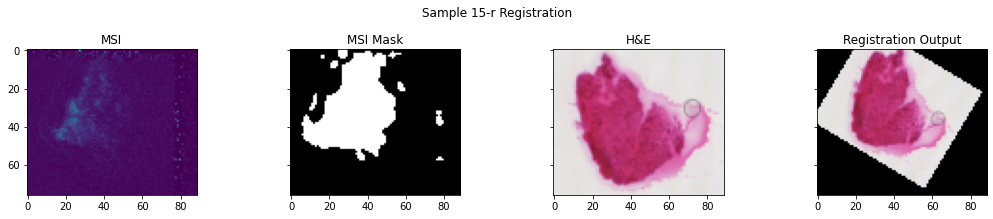

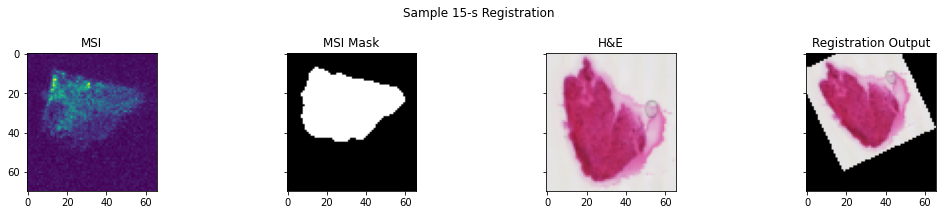

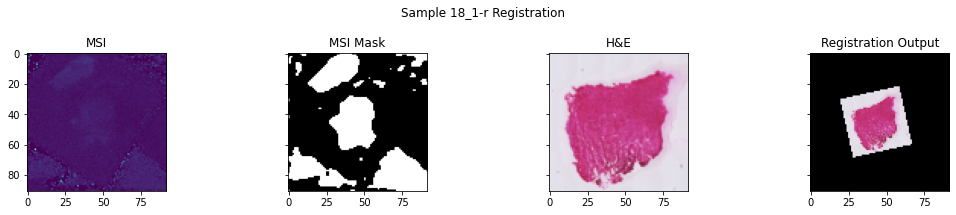

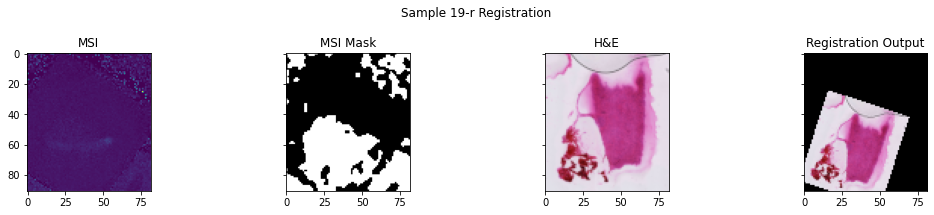

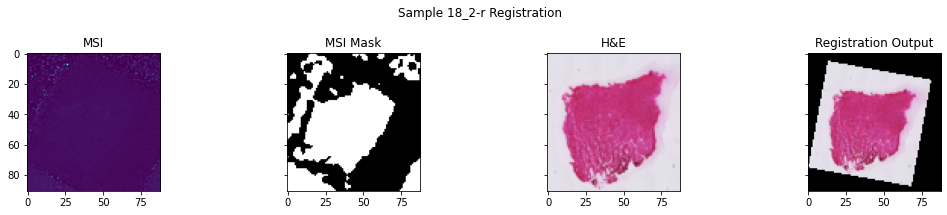

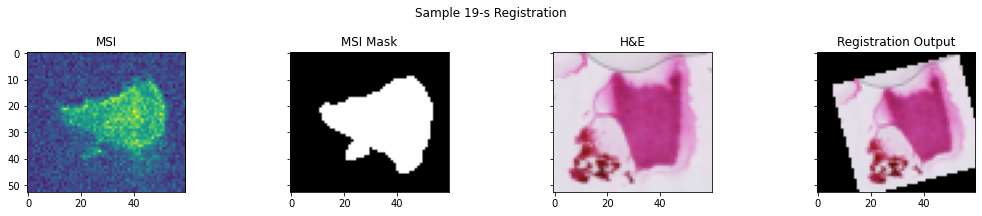

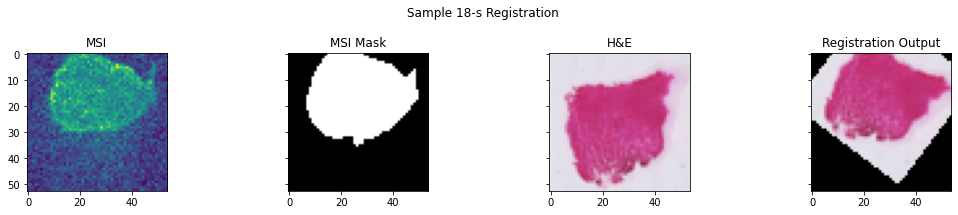

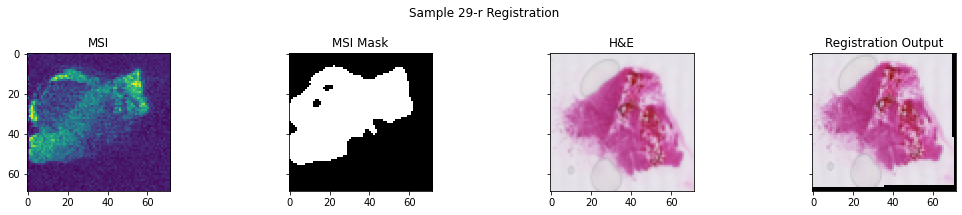

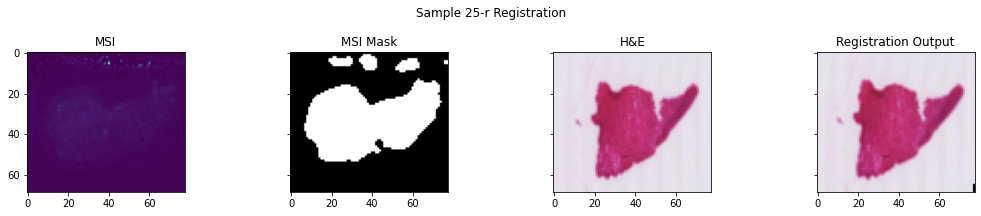

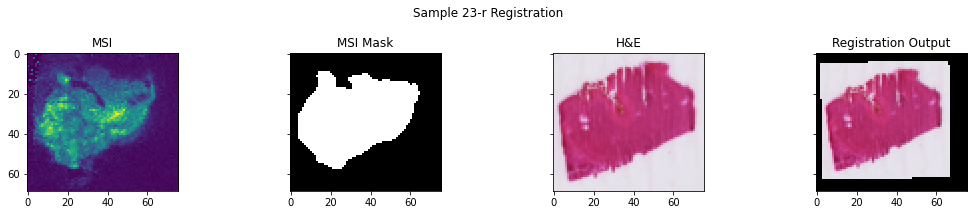

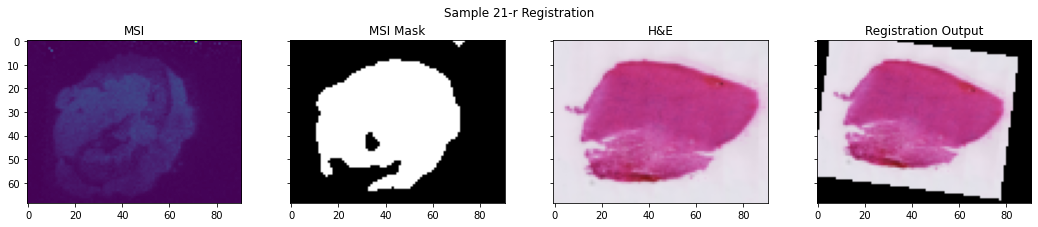

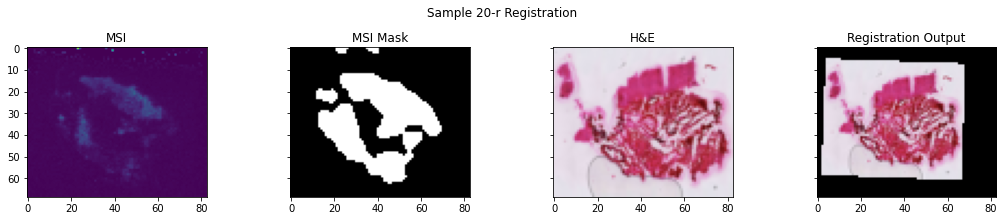

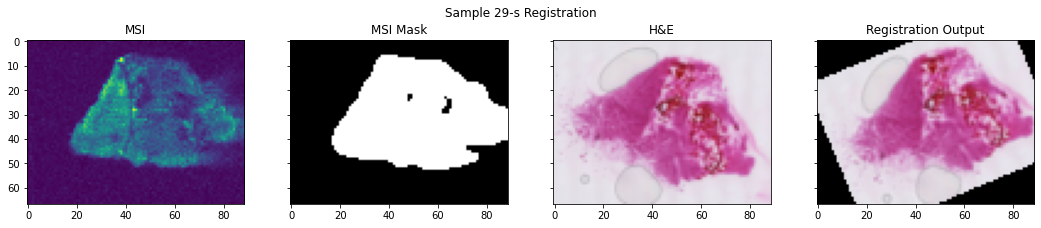

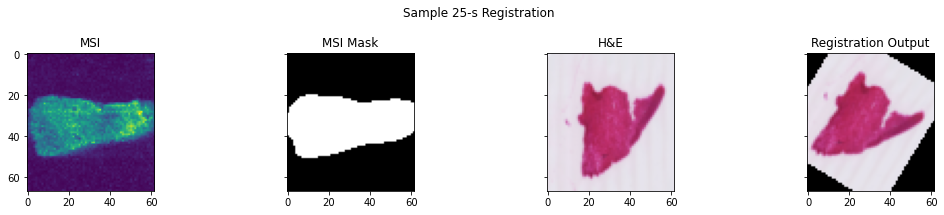

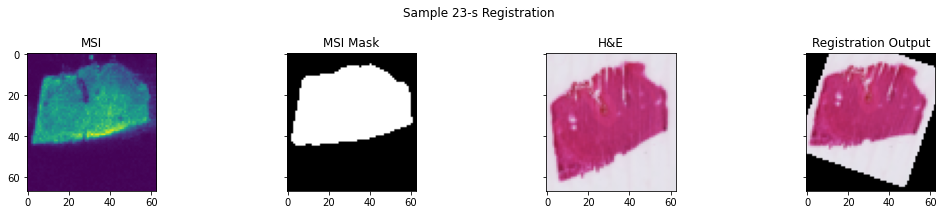

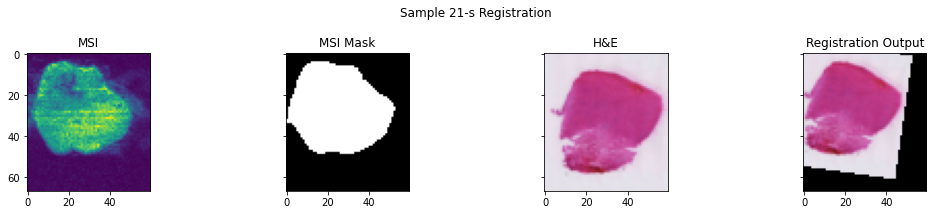

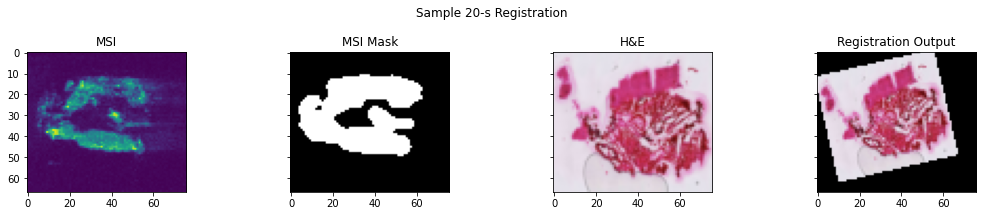

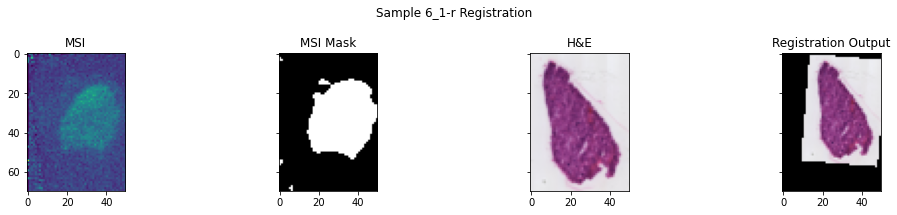

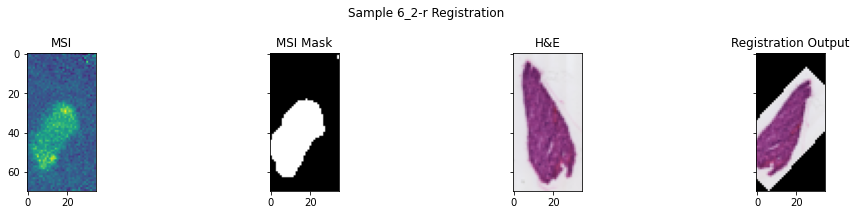

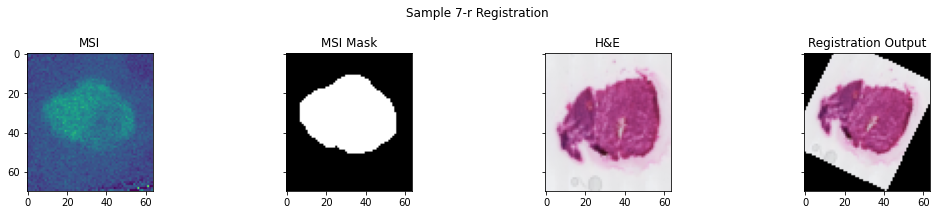

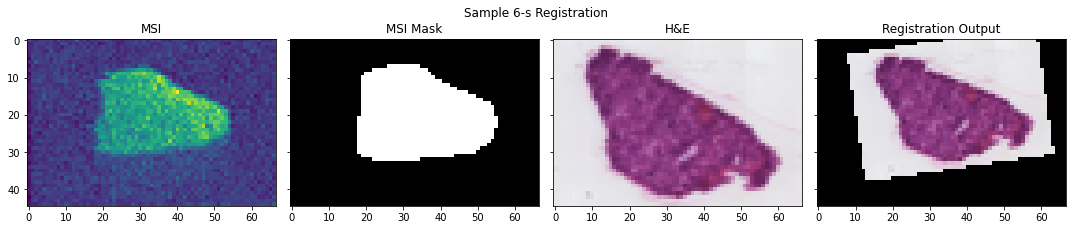

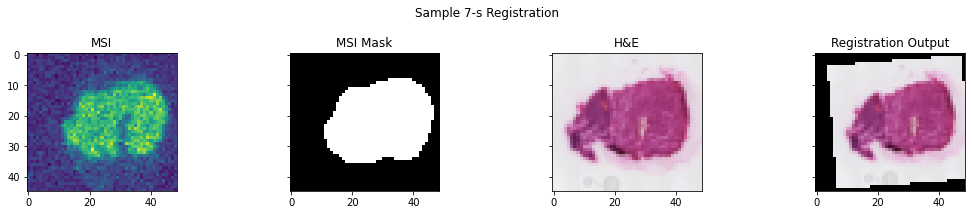

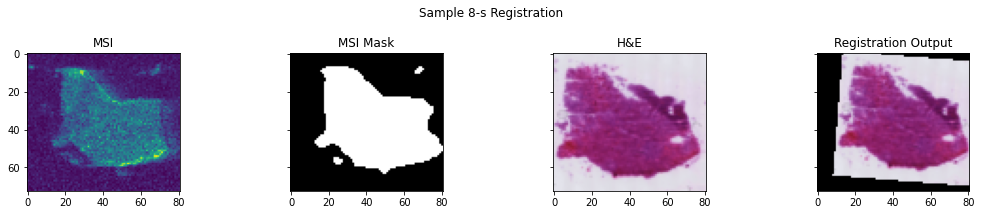

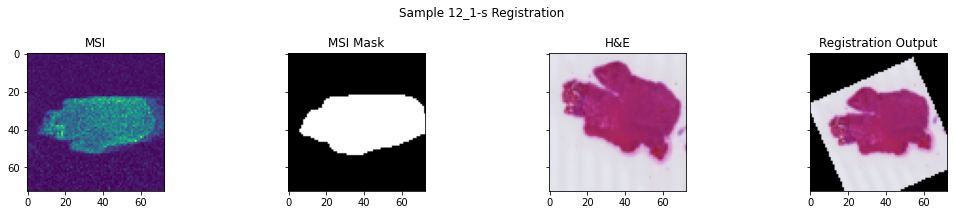

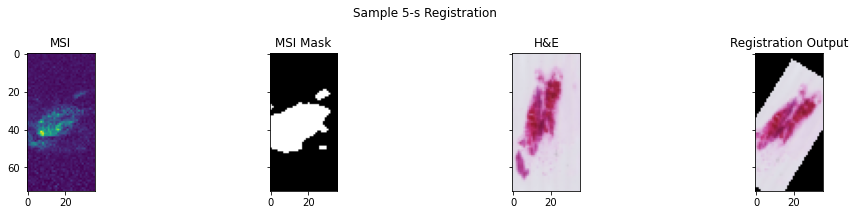

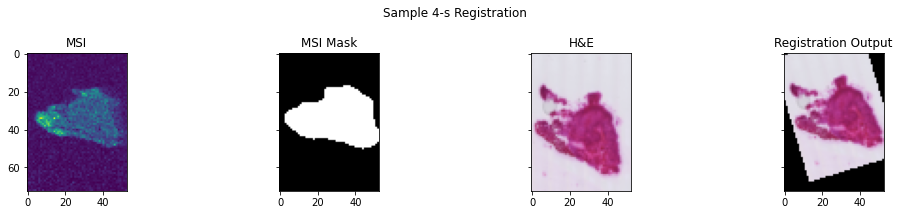

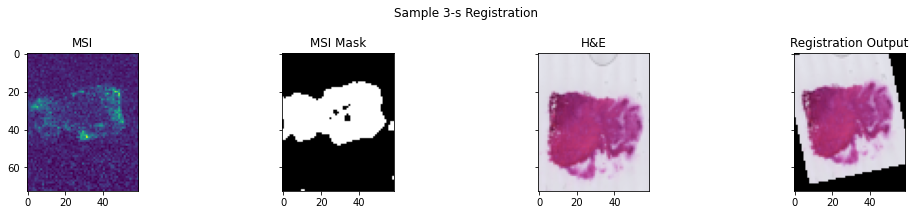

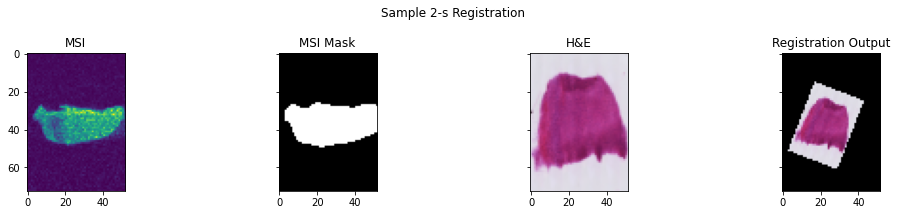

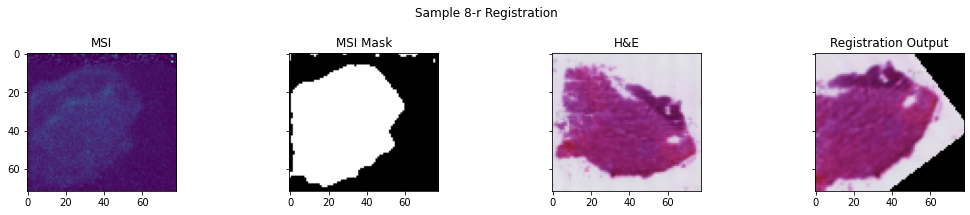

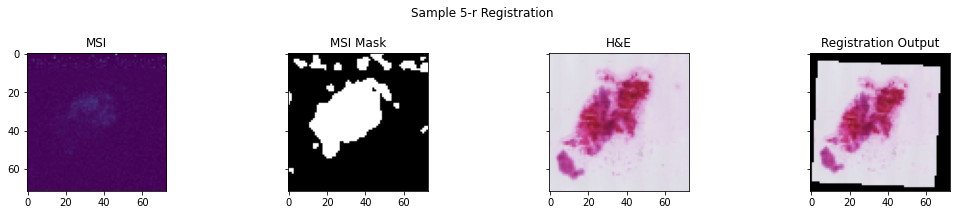

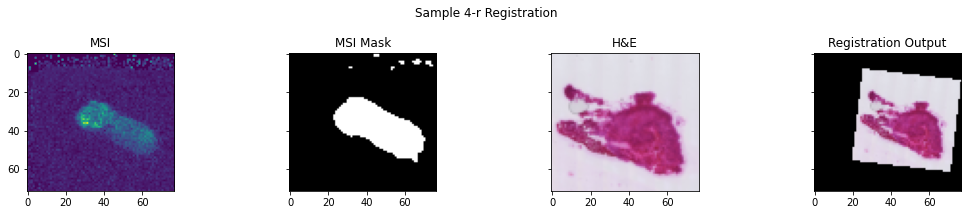

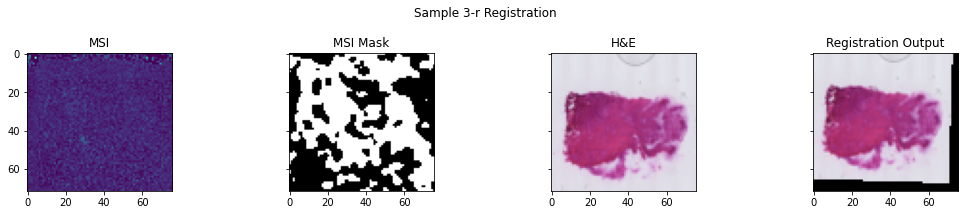

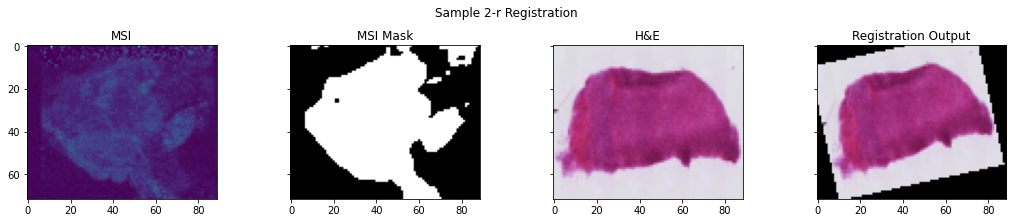

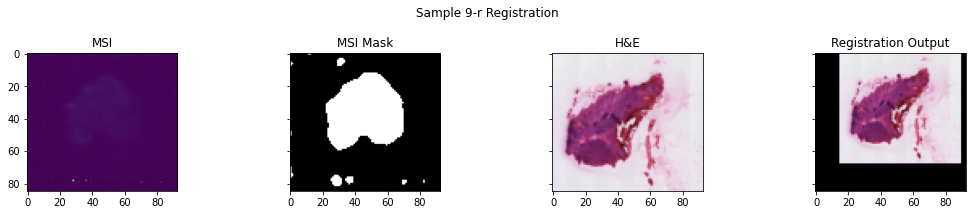

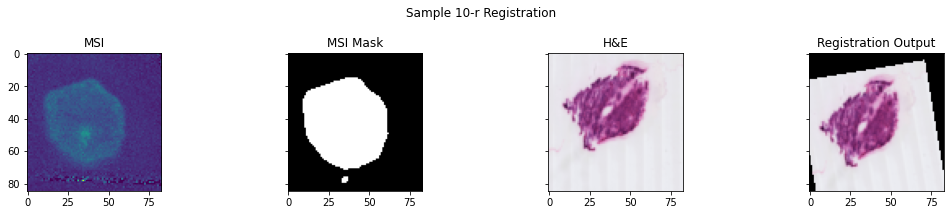

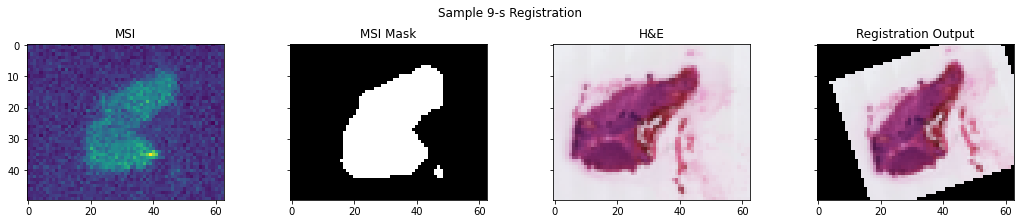

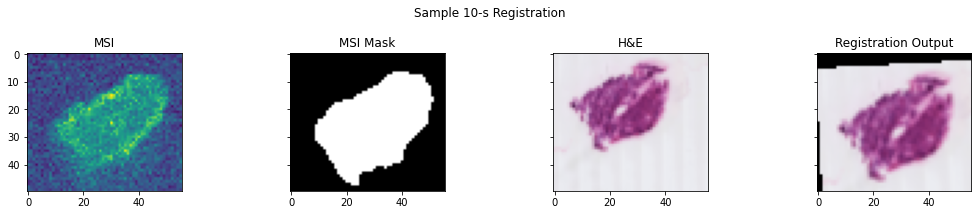

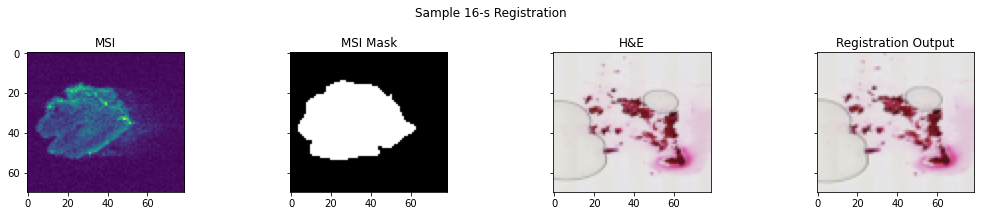

In [31]:
# get all mass spec images names
msi_names = np.asarray([f for f in os.listdir(msi_data_p) if f.endswith('.imzML')])

# loop over each mass spec image name and plot mz ion image
for msi_name in msi_names:
  # get file name
  he_name = msi_name.split('.')[0]
  # read H&E image
  try:
    he_img = io.imread(os.path.join(he_data_p, he_name + ".png"))
  
    # Parse the mass spec image imzML file
    with ImzMLParser(os.path.join(msi_data_p, msi_name)) as p_l:
      # Get ion image representation for each m/z value
      mz_imgs = get_ion_image(p_l, plot_mz, tol=plot_tol)

      # Create sum image of all m/z values
      msi_img = sum(mz_imgs)

      # Resize H&E image to MSI image shape
      he_img = transform.resize(he_img, msi_img.shape)

      # convert H&E image to grayscale
      he_gray = color.rgb2gray(1 - he_img)

      #
      msi_smooth = filters.gaussian(msi_img, sigma=1.5)
      he_smooth = filters.gaussian(he_gray, sigma=1.5)

      #
      msi_tresh = msi_smooth > filters.threshold_mean(msi_smooth)
      he_tresh = he_smooth > filters.threshold_mean(he_smooth)

      #
      fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True,
                                 figsize=(15,3))

      #
      axes[0].imshow(msi_img)
      axes[0].set_title('MSI')

      #
      axes[1].imshow(msi_tresh, cmap='gray')
      axes[1].set_title('MSI Mask')

      #
      axes[2].imshow(he_img)
      axes[2].set_title('H&E')

      #
      sr = StackReg(StackReg.SCALED_ROTATION)
      sr.register(msi_tresh, he_tresh)
      out = np.copy(he_img)
      for c in range(he_img.shape[2]):
        out[:, :, c] = sr.transform(out[:, :, c])
      axes[3].imshow(out)
      axes[3].set_title('Registration Output')

      # plot thresholding algorithms outputs
      fig.suptitle(f"Sample {he_name} Registration")
      plt.tight_layout()
      plt.show()
      
  except FileNotFoundError:
    print(he_name)

# Single Sample Registration:

In [ ]:
"""
# define mass spec image name
msi_name =  "14-r.imzML"
# define mass spec image path
msi_path = os.path.join(msi_data_p, msi_name)
# define H&E image name
he_name = "14-r.png"
# define H&E image path
he_path = os.path.join(he_data_p, he_name)
# Parse the mass spec image imzML file
with ImzMLParser(msi_path) as p_l:
  # Get ion image representation for each m/z value
  mz_imgs = get_ion_image(p_l, plot_mz, tol=plot_tol)
# Create sum image of all m/z values
msi_img = sum(mz_imgs)


#
# read H&E image
he_img = io.imread(he_path)
# Resize H&E image to MSI image shape
he_img = transform.resize(he_img, msi_img.shape)
# convert H&E image to grayscale
he_gray = color.rgb2gray(1 - he_img)


#
msi_smooth = filters.gaussian(msi_img, sigma=1.5)
he_smooth = filters.gaussian(he_gray, sigma=1.5)

#
msi_tresh = msi_smooth > filters.threshold_mean(msi_smooth)
he_tresh = he_smooth > filters.threshold_mean(he_smooth)


#
fig, axes = plt.subplots(nrows=1, ncols=7, sharex=True, sharey=True,
                           figsize=(20,3))

#
axes[0].imshow(msi_img)
axes[0].set_title('MSI')

#
axes[1].imshow(he_img)
axes[1].set_title('H&E')


#
transofmers = [StackReg.TRANSLATION, StackReg.RIGID_BODY,
               StackReg.SCALED_ROTATION, StackReg.AFFINE, StackReg.BILINEAR]

transofmers_str = ['TRANSLATION', "RIGID_BODY", "SCALED_ROTATION",
                   "AFFINE", "BILINEAR"]

#
for transformer, title, ax in zip(transofmers, transofmers_str, axes[2:]):
  sr = StackReg(transformer)
  sr.register(msi_tresh, he_tresh)
  out = np.copy(he_img)
  for c in range(he_img.shape[2]):
    out[:, :, c] = sr.transform(out[:, :, c])
  ax.imshow(out)
  ax.set_title(title)

# plot thresholding algorithms outputs
fig.suptitle(f"Sample {msi_name.split('.')[0]} Registration")
plt.tight_layout()
plt.show()
"""